## 📂 Load Dataset
We start by loading the Telco Customer Churn dataset from an Excel file.
- **Sheet Name:** `Telco_Churn`
- **Data Shape:** `(7043, 33)`
- **Goal:** Prepare data for preprocessing.


In [57]:
import pandas as pd

# Load the Excel file
file_path = "Telco_customer_churn.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to identify the relevant dataset
xls.sheet_names


# Load the dataset from the identified sheet
df = pd.read_excel(xls, sheet_name='Telco_Churn')

# Display basic information about the dataset
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

(None,
    CustomerID  Count        Country       State         City  Zip Code  \
 0  3668-QPYBK      1  United States  California  Los Angeles     90003   
 1  9237-HQITU      1  United States  California  Los Angeles     90005   
 2  9305-CDSKC      1  United States  California  Los Angeles     90006   
 3  7892-POOKP      1  United States  California  Los Angeles     90010   
 4  0280-XJGEX      1  United States  California  Los Angeles     90015   
 
                  Lat Long   Latitude   Longitude  Gender  ...        Contract  \
 0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
 1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
 2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
 3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
 4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   
 
   Paperless Billing             Payment Method

## 🛠 Data Preprocessing & Cleaning
Before training our models, we clean the dataset:
- Convert `Total Charges` to numeric and handle missing values.
- Drop unnecessary columns (`CustomerID`, `Country`, etc.).
- Fill missing values in `Churn Reason` with `"Unknown"`.


In [58]:
# Convert 'Total Charges' to numeric (some values might be empty spaces, so we handle errors)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Drop unnecessary columns
columns_to_drop = ['CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude']
df_cleaned = df.drop(columns=columns_to_drop)

# Fill missing values in 'Total Charges' with the median
df_cleaned['Total Charges'].fillna(df_cleaned['Total Charges'].median(), inplace=True)

# Fill missing values in 'Churn Reason' with 'Unknown'
df_cleaned['Churn Reason'].fillna('Unknown', inplace=True)

# Encode binary categorical features (Yes/No -> 1/0)
binary_cols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'Yes': 1, 'No': 0})

# Convert 'Churn Label' to binary (Yes -> 1, No -> 0)
df_cleaned['Churn Label'] = df_cleaned['Churn Label'].map({'Yes': 1, 'No': 0})

# Convert 'Multiple Lines' and similar categorical features into numerical categories
categorical_cols = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 
                    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
                    'Contract', 'Payment Method']

df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Display cleaned dataset
print(df_cleaned.head())  # View first few rows
print(df_cleaned.info())  # Check data types and missing values



   Count  Gender  Senior Citizen  Partner  Dependents  Tenure Months  \
0      1    Male               0        0           0              2   
1      1  Female               0        0           1              2   
2      1  Female               0        0           1              8   
3      1  Female               0        1           1             28   
4      1    Male               0        0           1             49   

   Phone Service  Paperless Billing  Monthly Charges  Total Charges  ...  \
0              1                  1            53.85         108.15  ...   
1              1                  1            70.70         151.65  ...   
2              1                  1            99.65         820.50  ...   
3              1                  1           104.80        3046.05  ...   
4              1                  1           103.70        5036.30  ...   

   Tech Support_Yes  Streaming TV_No internet service  Streaming TV_Yes  \
0             False                

C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\1505650206.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Total Charges'].fillna(df_cleaned['Total Charges'].median(), inplace=True)
C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\1505650206.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

## 🔢 Feature Engineering & Encoding
To make categorical variables usable for ML models:
- **Binary Encoding:** (`Yes/No` → `1/0`)
- **One-Hot Encoding:** Convert categorical features like `Internet Service`, `Payment Method`.
- **Target Variable Encoding:** `Churn Label (Yes → 1, No → 0)`.


## 📊 Exploratory Data Analysis (EDA)
Let's visualize the dataset to understand patterns and correlations:
- **Churn Distribution:** Count of `Churn = Yes/No`.
- **Feature Correlation:** Heatmap to analyze feature relationships.
- **Monthly Charges vs. Churn:** Boxplot to observe spending trends.
- **Tenure vs. Churn:** Histogram to check retention trends.


C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\1952489846.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cleaned['Churn Label'], palette="viridis")


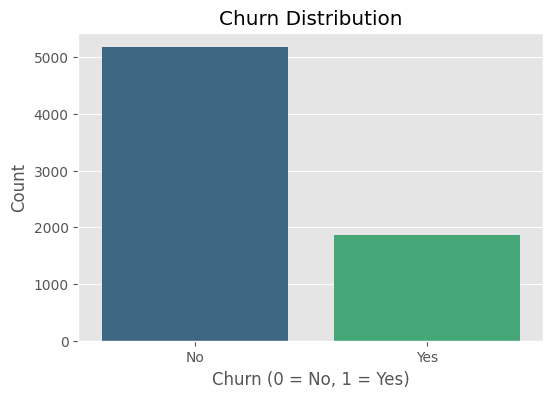

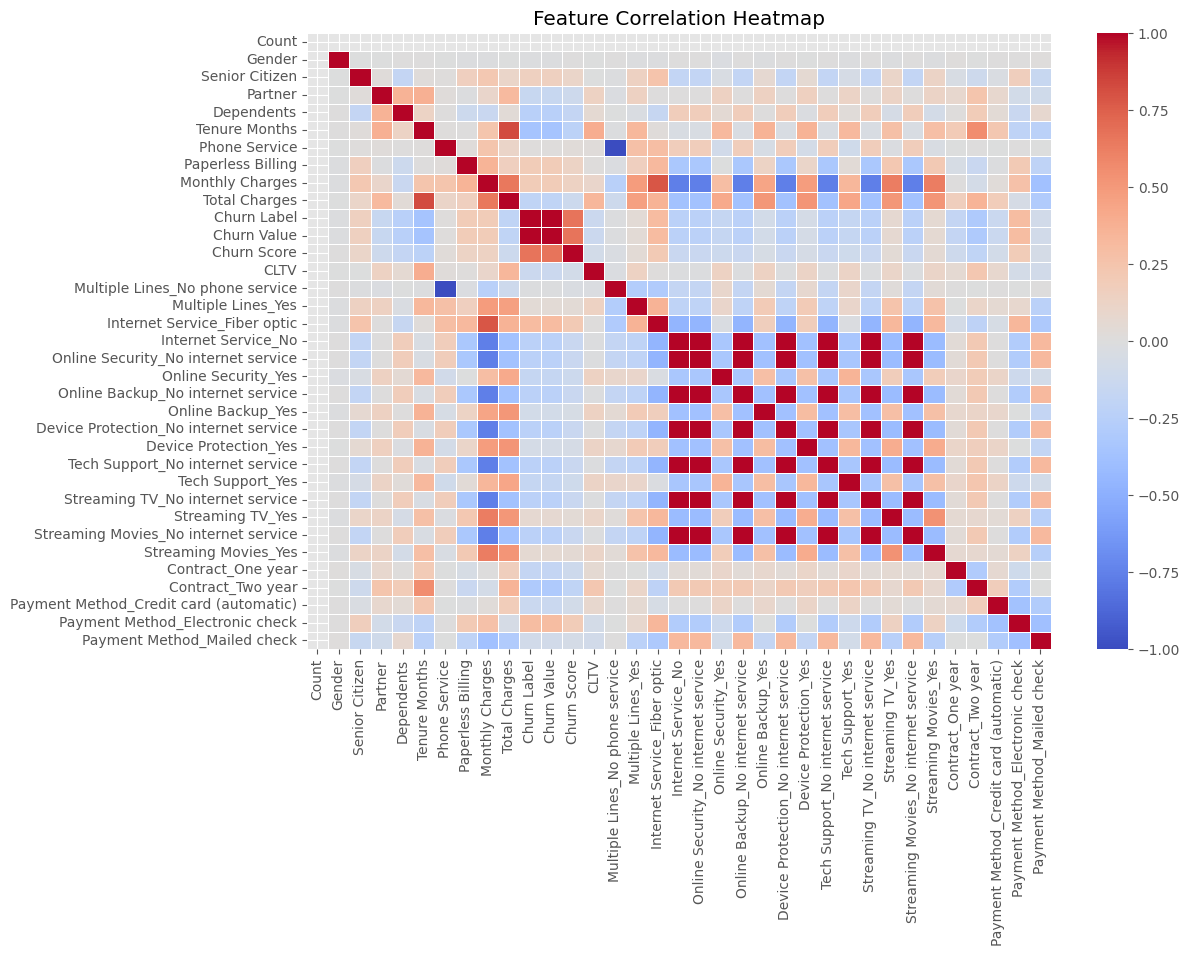

C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\1952489846.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_cleaned['Churn Label'], y=df_cleaned['Monthly Charges'], palette="coolwarm")


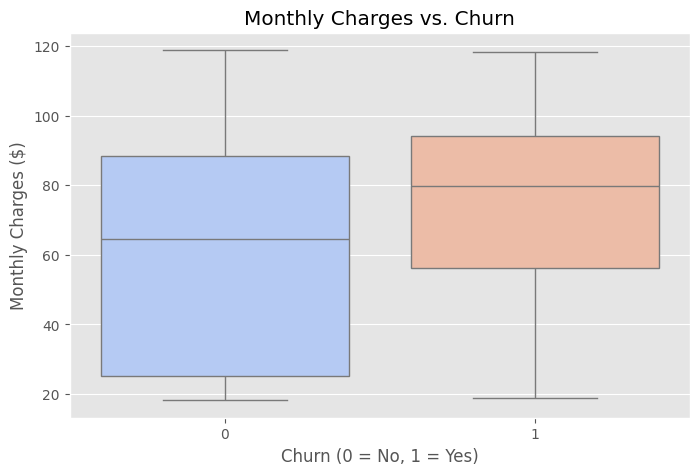

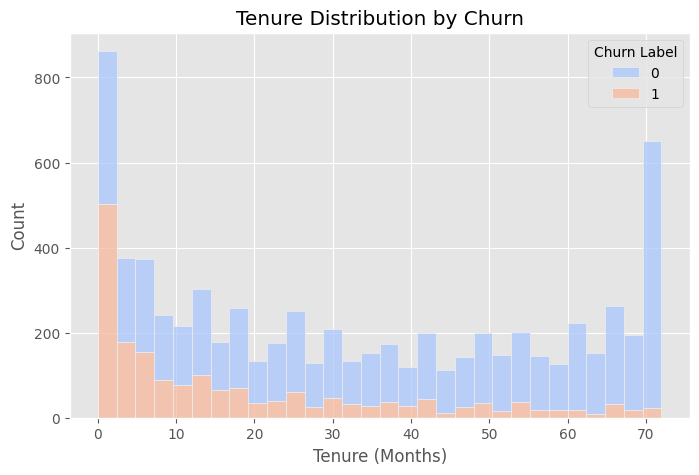

C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\1952489846.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.values, y=correlation.index, palette="coolwarm")


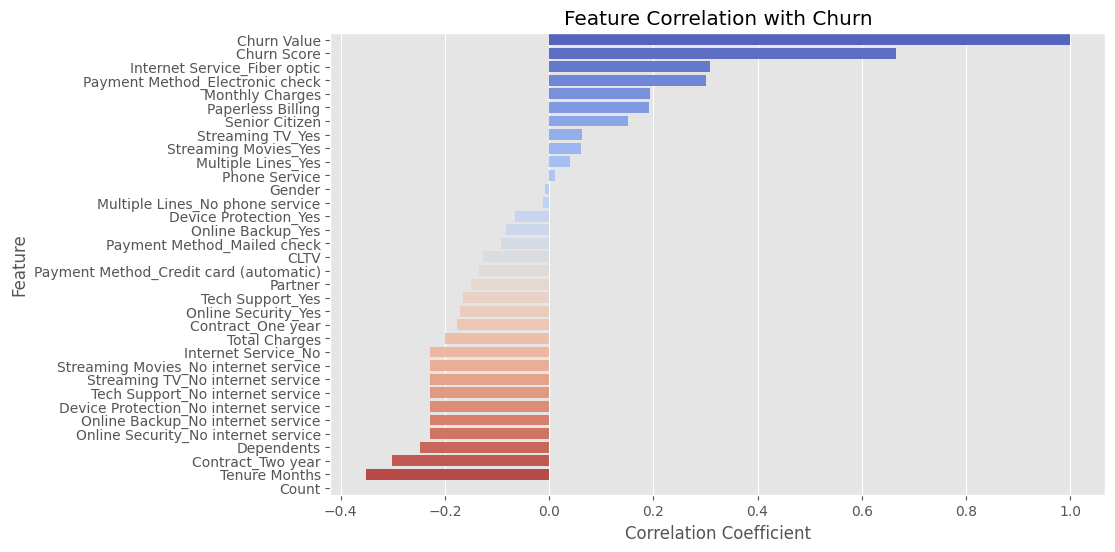

In [59]:
# Convert Gender column to binary (Male=1, Female=0)
df_cleaned['Gender'] = df_cleaned['Gender'].map({'Male': 1, 'Female': 0})
df_cleaned = df_cleaned.drop(columns=["Churn Reason"])

# # Ensure no other categorical columns exist before computing correlation
# print(df_cleaned.dtypes)  # Verify all columns are numeric


import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use("ggplot")

# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned['Churn Label'], palette="viridis")
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Monthly Charges vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned['Churn Label'], y=df_cleaned['Monthly Charges'], palette="coolwarm")
plt.title("Monthly Charges vs. Churn")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges ($)")
plt.show()

# Tenure vs. Churn
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned, x="Tenure Months", hue="Churn Label", multiple="stack", palette="coolwarm", bins=30)
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.show()

# Feature importance (basic correlation with Churn)
correlation = df_cleaned.corr()["Churn Label"].drop("Churn Label").sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette="coolwarm")
plt.title("Feature Correlation with Churn")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()


## 🤖 Train ML Models (Random Forest, XGBoost, SVM)
We train three models for churn prediction:
1️⃣ **Random Forest**
2️⃣ **XGBoost**
3️⃣ **Support Vector Machine (SVM)**

**Train-Test Split:** 80% training, 20% testing.  
**Class Imbalance Handling:** `class_weight="balanced"`.


Random Forest Accuracy: 0.7977
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
 [[937  98]
 [187 187]]
--------------------------------------------------
XGBoost Accuracy: 0.7807
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409

Confusion Matrix:
 [[906 129]
 [180 194]]
--------------------------------------------------


c:\Users\pjosh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM Accuracy: 0.6231
              precision    recall  f1-score   support

           0       0.86      0.58      0.70      1035
           1       0.39      0.73      0.51       374

    accuracy                           0.62      1409
   macro avg       0.62      0.66      0.60      1409
weighted avg       0.73      0.62      0.65      1409

Confusion Matrix:
 [[605 430]
 [101 273]]
--------------------------------------------------


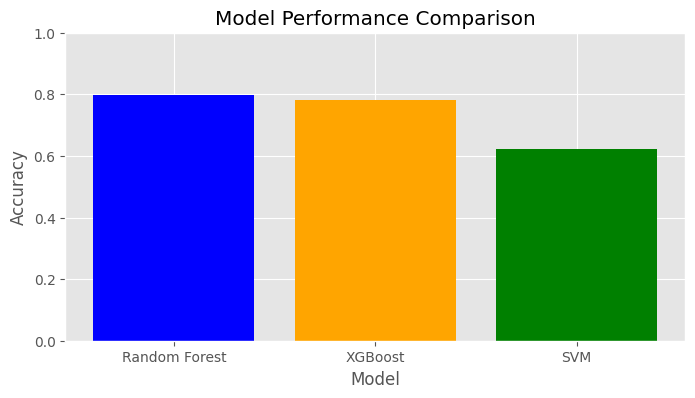

In [60]:
# import necessary libraries since execution state was reset
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Reload the dataset
file_path = "Telco_customer_churn.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Telco_Churn')

# Drop features causing data leakage
df_cleaned = df_cleaned.drop(columns=["Churn Value", "Churn Score"])

# Define features and target
X = df_cleaned.drop(columns=["Churn Label"])
y = df_cleaned["Churn Label"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models with SVM class weight balancing
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced")
}

# Train models and evaluate performance
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)

# Display results
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

# Show results to user
import matplotlib.pyplot as plt

# Plot model performance
plt.figure(figsize=(8, 4))
plt.bar(results_df["Model"], results_df["Accuracy"], color=["blue", "orange", "green"])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.show()





## 🔍 Hyperparameter Tuning with GridSearchCV
To improve model performance, we optimize:
- **Random Forest:** `n_estimators`, `max_depth`, `class_weight`
- **XGBoost:** `n_estimators`, `max_depth`, `learning_rate`

We use **GridSearchCV (3-fold cross-validation)** to find the best parameters.


In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#  Load Dataset
file_path = "Telco_customer_churn.xlsx"  # Update this with your local file path
df = pd.read_excel(file_path, sheet_name="Telco_Churn")

#  Drop Unnecessary Columns
columns_to_drop = [
    "CustomerID", "Country", "State", "City", "Zip Code", "Lat Long",
    "Latitude", "Longitude", "Churn Reason", "Churn Value", "Churn Score"
]
df_cleaned = df.drop(columns=columns_to_drop)

# Convert 'Total Charges' to Numeric & Fill Missing Values
df_cleaned['Total Charges'] = pd.to_numeric(df_cleaned['Total Charges'], errors='coerce')
df_cleaned["Total Charges"].fillna(df_cleaned["Total Charges"].median(), inplace=True)

# Encode Binary Categorical Features
binary_cols = ["Senior Citizen", "Partner", "Dependents", "Phone Service", "Paperless Billing"]
for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({"Yes": 1, "No": 0})

# Encode Target Variable
df_cleaned["Churn Label"] = df_cleaned["Churn Label"].map({"Yes": 1, "No": 0})

# Encode Gender
df_cleaned["Gender"] = df_cleaned["Gender"].map({"Male": 1, "Female": 0})

# One-Hot Encode Categorical Features
categorical_cols = [
    "Multiple Lines", "Internet Service", "Online Security", "Online Backup",
    "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies",
    "Contract", "Payment Method"
]
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Split Features & Target
X = df_cleaned.drop(columns=["Churn Label"])
y = df_cleaned["Churn Label"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define Hyperparameter Grids
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "class_weight": ["balanced"]
}

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2]
}

# Initialize Models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Perform Grid Search for XGBoost
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)

# Get Best Parameters
best_rf_params = rf_grid_search.best_params_
best_xgb_params = xgb_grid_search.best_params_

# Print Results
print("Best Random Forest Parameters:", best_rf_params)
print("Best XGBoost Parameters:", best_xgb_params)


C:\Users\pjosh\AppData\Local\Temp\ipykernel_4704\2602910067.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["Total Charges"].fillna(df_cleaned["Total Charges"].median(), inplace=True)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Random Forest Parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 100}
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


c:\Users\pjosh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 📈 Model Evaluation
We compare the performance of Random Forest and XGBoost:
- **Accuracy**
- **Precision & Recall**
- **Confusion Matrix**

Since **churn prediction is imbalanced**, we focus on **recall for `Churn=1`** (avoiding false negatives).


In [62]:
# Train optimized Random Forest
rf_optimized = RandomForestClassifier(
    class_weight='balanced', max_depth=None, n_estimators=100, random_state=42
)
rf_optimized.fit(X_train, y_train)
y_pred_rf = rf_optimized.predict(X_test)

# Train optimized XGBoost
xgb_optimized = XGBClassifier(
    learning_rate=0.1, max_depth=3, n_estimators=100, eval_metric="logloss", random_state=42
)
xgb_optimized.fit(X_train, y_train)
y_pred_xgb = xgb_optimized.predict(X_test)

# Evaluate both models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("-" * 50)

print("XGBoost Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))




Random Forest Performance
Accuracy: 0.7991483321504613
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
 [[935 100]
 [183 191]]
--------------------------------------------------
XGBoost Performance
Accuracy: 0.8048261178140526
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

Confusion Matrix:
 [[933 102]
 [173 201]]


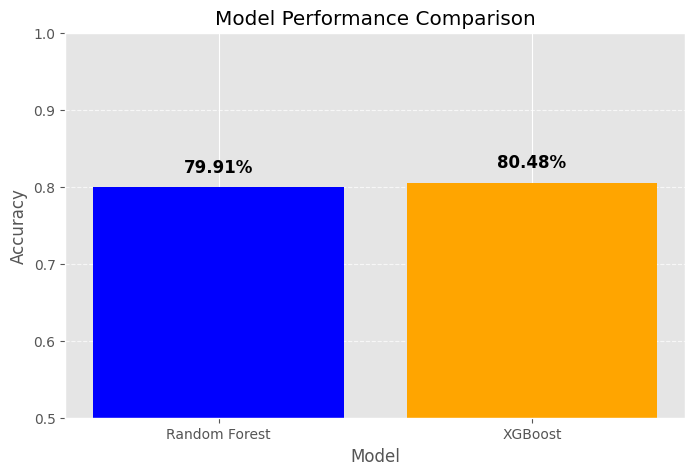

In [63]:
import matplotlib.pyplot as plt

# Model Performance Metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

# Labels and Values
models = ["Random Forest", "XGBoost"]
accuracies = [rf_accuracy, xgb_accuracy]

# Create Bar Chart for Model Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=["blue", "orange"])
plt.ylim(0.5, 1)  # Set y-axis limit for better visualization
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add percentage labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{acc:.2%}", ha="center", fontsize=12, fontweight="bold")

# Show the plot
plt.show()


In [64]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_optimized, "xgb_churn_model.pkl")


['xgb_churn_model.pkl']

In [65]:
print(X_train.columns)
print("Expected feature count:", X_train.shape[1])


Index(['Count', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Paperless Billing',
       'Monthly Charges', 'Total Charges', 'CLTV',
       'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No internet service', 'Tech Support_Yes',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No internet service', 'Streaming Movies_Yes',
       'Contract_One year', 'Contract_Two year',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check'],
      dtype='object')
Expected feature count: 32


## 🔥 Feature Importance with SHAP
To understand which features impact churn the most, we use:
- **SHAP Summary Plot**
- **Feature Impact on Model Decisions**
- **Correlation with Churn Label**


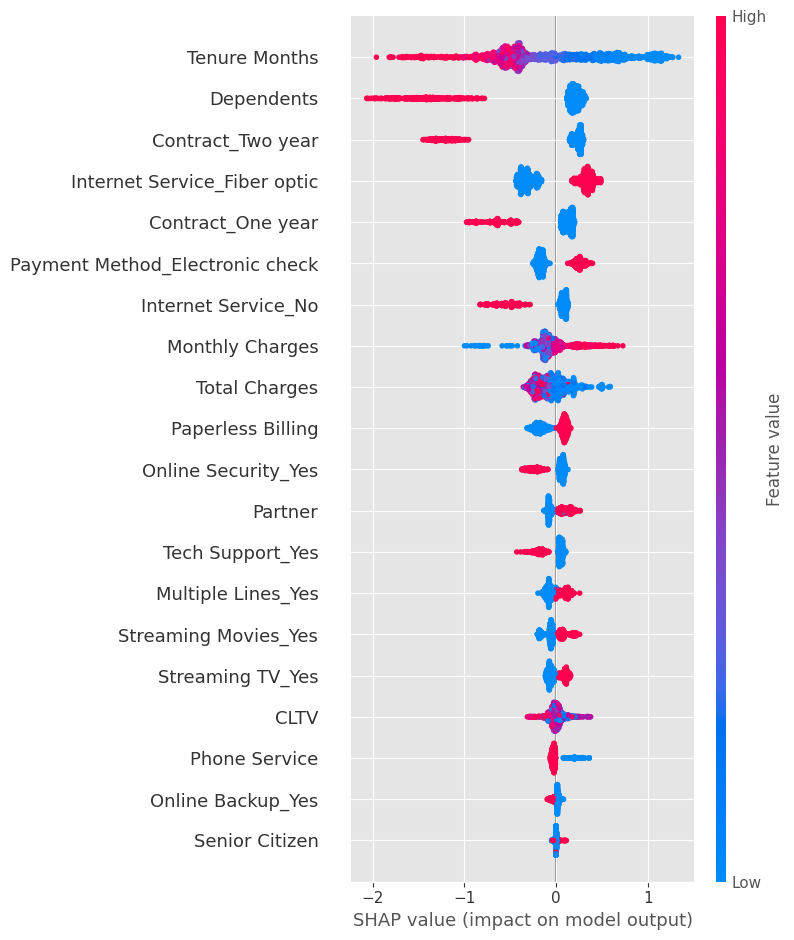

In [66]:
import shap

# Initialize SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_optimized)
shap_values = explainer(X_test)

# Summary Plot - Feature Importance
shap.summary_plot(shap_values, X_test)

## 🚀 Streamlit App Deployment
Built an interactive **web-based churn prediction app** using:
- **User Input Fields** (Tenure, Monthly Charges, etc.)
- **Churn Probability Prediction**
- **Interactive UI Enhancements**
